# Basis function construction



This now creates basis functions for both the observations and for a week(?) of mobile data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import datetime

## Load grid 

(we'll need to filter this down)

In [2]:
grid_gdf = geopandas.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")

<Axes: >

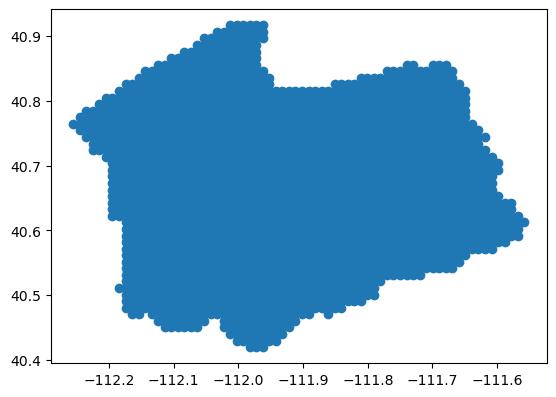

In [3]:
grid_gdf.plot()

In [4]:
grid_crds = grid_gdf.get_coordinates()
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()
print(min_x, max_x, min_y, max_y)


-112.25516635714284 -111.55831564285714 40.419293290000006 40.916769710000004


In [5]:
grid_crds['normalized_lon'] = (grid_crds['x']-min_x)/(max_x - min_x)
grid_crds['normalized_lat'] = (grid_crds['y']-min_y)/(max_y-min_y)


## Load monitor data

In [6]:
aq_df = pd.read_csv("./data/aqs_data.csv")
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement
0,2005,40.598056,-111.894167,Ozone,2023-01-01T00:00:00Z,2023-01-01,0S,0.014
1,2005,40.598056,-111.894167,Ozone,2023-01-01T01:00:00Z,2023-01-01,1H 0M 0S,0.007
2,2005,40.598056,-111.894167,Ozone,2023-01-01T02:00:00Z,2023-01-01,2H 0M 0S,0.002
3,2005,40.598056,-111.894167,Ozone,2023-01-01T03:00:00Z,2023-01-01,3H 0M 0S,0.009
4,2005,40.598056,-111.894167,Ozone,2023-01-01T04:00:00Z,2023-01-01,4H 0M 0S,0.011


In [7]:
aq_df['day_time'].max()

'2023-09-30T23:00:00Z'

In [8]:
aq_df = aq_df[(aq_df.day_time >= "2023-07-01") & (aq_df.day_time <= "2023-07-15")]

In [9]:
aq_df['day_time'].max()

'2023-07-14T23:00:00Z'

In [10]:
aq_df.shape

(2665, 8)

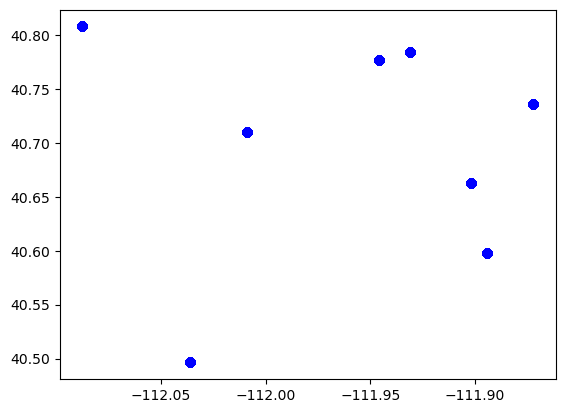

In [11]:
plt.plot(aq_df['longitude'], aq_df['latitude'], 'bo')

### Standardize coordinates

In [12]:
lon = aq_df.values[:,2].astype('float64')
lat = aq_df.values[:,1].astype('float64')
aq_df['normalized_lon'] = (lon-min_x)/(max_x - min_x)
aq_df['normalized_lat'] = (lat-min_y)/(max_y-min_y)
N = lon.shape[0]
print(N)

2665


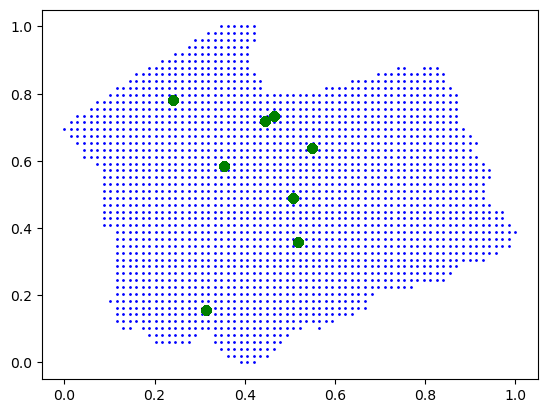

In [13]:
plt.plot(grid_crds['normalized_lon'], grid_crds['normalized_lat'], 'bo', markersize=1)
plt.plot(aq_df['normalized_lon'], aq_df['normalized_lat'], 'go')
plt.show()

### Standardize time

In [14]:
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement,normalized_lon,normalized_lat
4310,2005,40.598056,-111.894167,Ozone,2023-07-01T00:00:00Z,2023-07-01,0S,0.033,0.518044,0.359339
4311,2005,40.598056,-111.894167,Ozone,2023-07-01T01:00:00Z,2023-07-01,1H 0M 0S,0.033,0.518044,0.359339
4312,2005,40.598056,-111.894167,Ozone,2023-07-01T02:00:00Z,2023-07-01,2H 0M 0S,0.031,0.518044,0.359339
4313,2005,40.598056,-111.894167,Ozone,2023-07-01T03:00:00Z,2023-07-01,3H 0M 0S,0.023,0.518044,0.359339
4314,2005,40.598056,-111.894167,Ozone,2023-07-01T04:00:00Z,2023-07-01,4H 0M 0S,0.021,0.518044,0.359339


In [15]:
day_time = pd.to_datetime(aq_df['day_time'])
# add the timezone:

print(day_time[0:10])
print(day_time.dtype)

4310   2023-07-01 00:00:00+00:00
4311   2023-07-01 01:00:00+00:00
4312   2023-07-01 02:00:00+00:00
4313   2023-07-01 03:00:00+00:00
4314   2023-07-01 04:00:00+00:00
4315   2023-07-01 05:00:00+00:00
4316   2023-07-01 06:00:00+00:00
4317   2023-07-01 07:00:00+00:00
4318   2023-07-01 08:00:00+00:00
4319   2023-07-01 09:00:00+00:00
Name: day_time, dtype: datetime64[ns, UTC]
datetime64[ns, UTC]


In [16]:
day_time = day_time.astype('int64') / 1e9 ## Time in nanoseconds

In [17]:
min_t = day_time.min()
max_t = day_time.max()
print(min_t, max_t)

1688169600.0 1689375600.0


In [18]:
aq_df['normalized_time'] = (day_time - min_t) / (max_t-min_t)
aq_df['normalized_time']

4310     0.000000
4311     0.002985
4312     0.005970
4313     0.008955
4314     0.011940
           ...   
49958    0.988060
49959    0.991045
49960    0.994030
49961    0.997015
49962    1.000000
Name: normalized_time, Length: 2665, dtype: float64

## Load ebus data

In [19]:
ebus = pd.read_csv("./data/EBUS_TEST_DATA/BUS04_2023_07.csv", header = [0,1],  
                 na_values = -9999.00)
ebus.shape

(183866, 27)

In [20]:
ebus.head()

,Timestamp,Latitude,Longitude,Elevation,GPS_Speed,GPS_Direction,GPS_RMC_Valid,Battery_Voltage,Bus_Box_Temperature,Bus_Top_Temperature,...,ES405_Internal_Relative_Humidity,ES405_Internal_Air_Pressure,ES405_Error_Code,2B_Ozone_Concentration,2B_Air_Flow_Rate,2B_Internal_Air_Temperature,2B_Internal_Air_Pressure,PM2.5_Data_Flagged,Ozone_Data_Flagged,GPS_Data_Flagged
,UTC,ddeg,ddeg,m,m/s,deg,binary,volts,degC,degC,...,%,hpa,code,ppbv,L/min,degC,hpa,binary,binary,binary
0,2023-07-01T00:00:00,40.703491,-111.977234,1293.5,0.0,181.8,1.0,13.17,31.57,29.47,...,18.8,655.6,0.0,62.7,2.13,42.8,842.5,0,0,0
1,2023-07-01T00:00:05,40.703499,-111.977234,1293.9,0.0,181.8,1.0,13.17,31.57,29.49,...,NaN,NaN,NaN,55.3,2.13,42.8,842.8,0,0,0
2,2023-07-01T00:00:10,40.703499,-111.977234,1293.9,0.0,181.8,1.0,13.18,31.57,29.50,...,NaN,NaN,NaN,53.7,2.12,42.8,842.8,0,0,0
3,2023-07-01T00:00:15,40.703499,-111.977234,1293.9,0.0,181.8,1.0,13.18,31.56,29.49,...,NaN,NaN,NaN,57.3,2.13,42.8,842.5,0,0,0
4,2023-07-01T00:00:20,40.703499,-111.977234,1293.9,0.0,181.8,1.0,13.17,31.56,29.51,...,NaN,NaN,NaN,48.4,2.14,42.8,842.5,0,0,0


Crop out relevant data

In [21]:
ebus2 = pd.DataFrame({
    'time': pd.to_datetime(ebus.iloc[:,0]),
    'lon': ebus.iloc[:,2],
    'lat': ebus.iloc[:,1]
    })

In [22]:
ebus2['val'] = ebus['2B_Ozone_Concentration'] / 1000
ebus2

,time,lon,lat,val
0,2023-07-01 00:00:00,-111.977234,40.703491,0.0627
1,2023-07-01 00:00:05,-111.977234,40.703499,0.0553
2,2023-07-01 00:00:10,-111.977234,40.703499,0.0537
3,2023-07-01 00:00:15,-111.977234,40.703499,0.0573
4,2023-07-01 00:00:20,-111.977234,40.703499,0.0484
...,...,...,...,...
183861,2023-07-31 19:03:00,-111.910347,40.761238,NaN
183862,2023-07-31 19:03:05,-111.910347,40.761261,NaN
183863,2023-07-31 19:03:10,-111.910378,40.761288,NaN
183864,2023-07-31 19:03:15,-111.910477,40.761395,NaN


Crop to time

In [23]:
ebus2 = ebus2[(ebus2.time >= "2023-07-01") & (ebus2.time <= "2023-07-14 23:00:00")].copy()

In [24]:
ebus2.shape

(94272, 4)

In [25]:
ebus2['time'].max()

Timestamp('2023-07-14 23:00:00')

### Standardize coordinates

In [26]:
ebus2['normalized_lon'] = (ebus2['lon']-min_x)/(max_x - min_x)
ebus2['normalized_lat'] = (ebus2['lat']-min_y)/(max_y-min_y)

In [27]:
ebus2

,time,lon,lat,val,normalized_lon,normalized_lat
0,2023-07-01 00:00:00,-111.977234,40.703491,0.0627,0.398841,0.571279
1,2023-07-01 00:00:05,-111.977234,40.703499,0.0553,0.398841,0.571295
2,2023-07-01 00:00:10,-111.977234,40.703499,0.0537,0.398841,0.571295
3,2023-07-01 00:00:15,-111.977234,40.703499,0.0573,0.398841,0.571295
4,2023-07-01 00:00:20,-111.977234,40.703499,0.0484,0.398841,0.571295
...,...,...,...,...,...,...
94267,2023-07-14 22:59:40,-111.916893,40.733463,0.0454,0.485432,0.631527
94268,2023-07-14 22:59:45,-111.916924,40.732914,0.0552,0.485387,0.630423
94269,2023-07-14 22:59:50,-111.916946,40.732399,0.0507,0.485356,0.629388
94270,2023-07-14 22:59:55,-111.916946,40.731895,0.0413,0.485356,0.628375


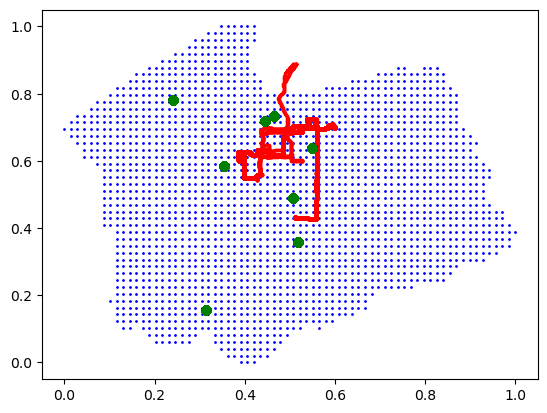

In [28]:
plt.plot(grid_crds['normalized_lon'], grid_crds['normalized_lat'], 'bo', markersize=1)
plt.plot(ebus2['normalized_lon'], ebus2['normalized_lat'], 'ro', markersize = 1.5)
plt.plot(aq_df['normalized_lon'], aq_df['normalized_lat'], 'go')
plt.show()

### Standardize time

In [29]:
day_time = ebus2['time'].astype('int64') / 1e9 ## Time in nanoseconds
ebus2['normalized_time'] = (day_time - min_t) / (max_t-min_t)
ebus2['normalized_time']

0        0.000000
1        0.000004
2        0.000008
3        0.000012
4        0.000017
           ...   
94267    0.999983
94268    0.999988
94269    0.999992
94270    0.999996
94271    1.000000
Name: normalized_time, Length: 94272, dtype: float64

## Basis functions

### Time

We need to define:
- Number of basis layers (3)
- Number of knots per layer
- S.D. for Gaussian function

Then make a ragged array holding the knots on the normalized scale.

Note that one of the previous examples has a very high number of temporal knots (~800) which is very computationally expensive

In [30]:
## time basis 
## 14 day basis function
num_basis = [10,20,56]
std_arr = [0.3,0.15,0.05]
# num_basis = [10,15,45]
# std_arr = [0.4,0.2,0.1]
#num_basis = [70,250,410]
#std_arr = [0.2,0.09,0.009]
#std_arr = [0.3,0.15,0.05]

mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]

In [31]:
mu_knots

[array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([0.        , 0.01818182, 0.03636364, 0.05454545, 0.07272727,
        0.09090909, 0.10909091, 0.12727273, 0.14545455, 0.16363636,
        0.18181818, 0.2       , 0.21818182, 0.23636364, 0.25454545,
        0.27272727, 0.29090909, 0.30909091, 0.32727273, 0.34545455,
        0.36363636, 0.38181818, 0.4       , 0.41818182, 0.43636364,
        0.45454545, 0.47272727, 0.49090909, 0.50909091, 0.52727273,
        0.54545455, 0.56363636, 0.58181818, 0.6       , 0.61818182,
        0.63636364, 0.65454545, 0.67272727, 0.69090909, 0.70909091,
        0.72727273, 0.74545455, 0.76363636, 

#### Monitor data

Now create the basis functions. This does the following:
- Loop over each basis layer
- Loop by knot in the selected layer
- Get distance from each observation (held in `s`) to the knot
- Estimate Gaussian weight

In [32]:
s = np.array(aq_df['normalized_time']).reshape(len(aq_df),1)
print(s.shape)
N_data = len(aq_df)
N = N_data ## We have a separate N for the training + test data set (no testing at present)
print(N)

(2665, 1)
2665


In [33]:
phi_t1 = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t1[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t1[j,i + K] = 0
    K = K + num_basis[res]

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_72417/1304893475.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t1[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


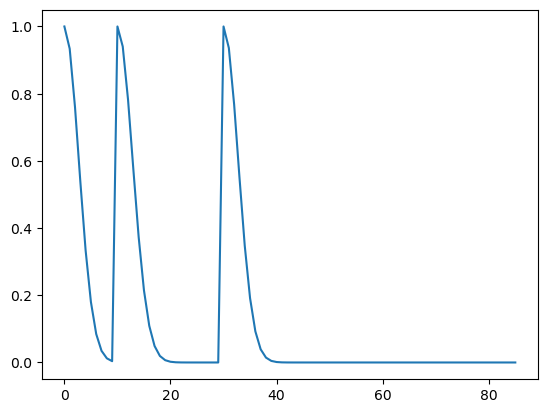

In [34]:
plt.plot(phi_t1[0,:])

#### Mobile data

In [35]:
s = np.array(ebus2['normalized_time']).reshape(len(ebus2),1)
print(s.shape)
N_data = len(ebus2)
N = N_data ## We have a separate N for the training + test data set (no testing at present)
print(N)

(94272, 1)
94272


In [36]:
s

array([[0.00000000e+00],
       [4.14593698e-06],
       [8.29187396e-06],
       ...,
       [9.99991708e-01],
       [9.99995854e-01],
       [1.00000000e+00]])

In [37]:
phi_t2 = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t2[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t2[j,i + K] = 0
    K = K + num_basis[res]

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_72417/2871447583.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t2[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


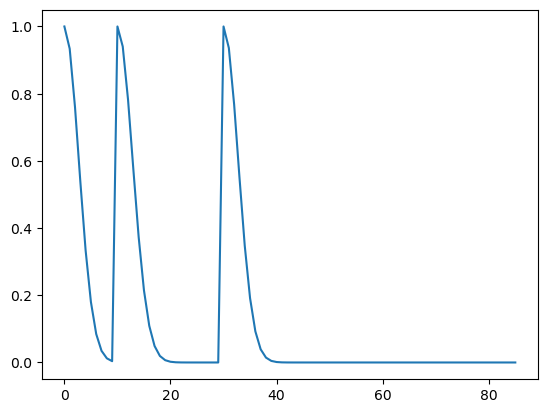

In [38]:
plt.plot(phi_t2[0,:])

### Space

In [39]:
## Knots for spatial dimension (from STDK example)
num_basis = [5**2,9**2,11**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]

#### Monitor data

In [40]:
## Make array of coordinates
s = np.vstack((aq_df['normalized_lon'],aq_df['normalized_lat'])).T
N = len(aq_df)

In [41]:
## Get weights from Wendland kernel
K = 0
phi_s1 = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_s1[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi_s1[j,i + K] = 0
    K = K + num_basis[res]

Basis function for first location

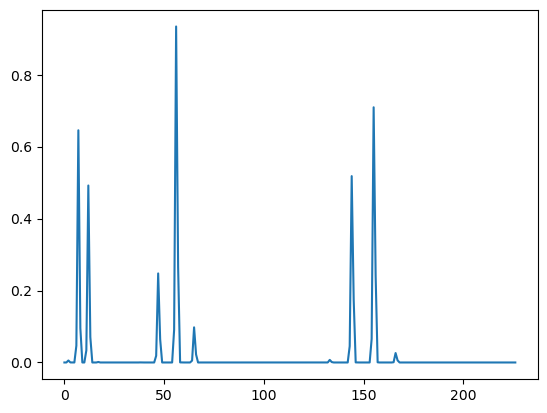

In [42]:
plt.plot(phi_s1[0,:])

In [43]:
x = phi_s1[0,0:25]
x = x.reshape(5, 5)

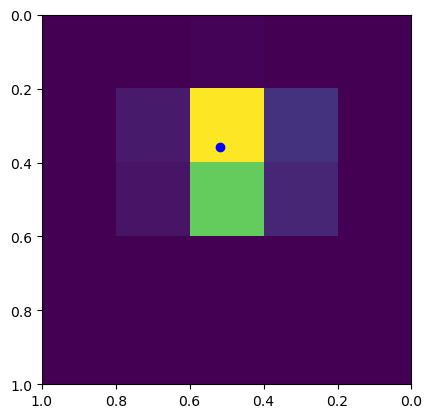

In [44]:
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(aq_df['normalized_lon'].iloc[0], aq_df['normalized_lat'].iloc[0], 'bo')
plt.show()

In [45]:
num_basis

[25, 81, 121]

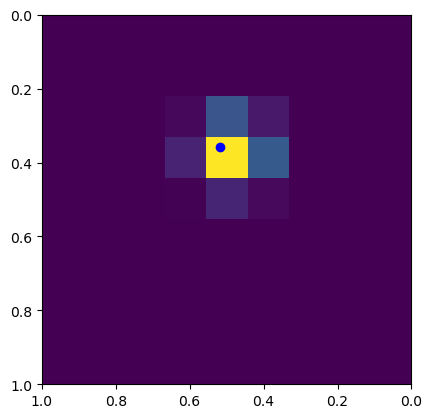

In [46]:
x = phi_s1[0,25:106]
x = x.reshape(9, 9)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(aq_df['normalized_lon'].iloc[0], aq_df['normalized_lat'].iloc[0], 'bo')
plt.show()


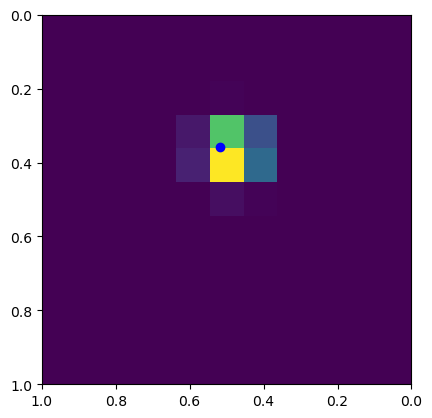

In [47]:
x = phi_s1[0,106:227]
x = x.reshape(11, 11)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(aq_df['normalized_lon'].iloc[0], aq_df['normalized_lat'].iloc[0], 'bo')
plt.show()


#### Mobile data

In [48]:
## Make array of coordinates
s = np.vstack((ebus2['normalized_lon'],ebus2['normalized_lat'])).T
N = len(ebus2)

In [49]:
## Get weights from Wendland kernel
K = 0
phi_s2 = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_s2[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi_s2[j,i + K] = 0
    K = K + num_basis[res]

## Output

### Monitors
Check dimensions and stack (column bind)

In [50]:
print(phi_t1.shape)
print(phi_s1.shape)

phi_1 = np.hstack((phi_t1,phi_s1))

(2665, 86)
(2665, 227)


Remove any columns with all zeros (basis functions not linked to obs)

In [51]:
idx_zero = np.array([], dtype=int)
for i in range(phi_1.shape[1]):
    if sum(phi_1[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_1_reduce = np.delete(phi_1,idx_zero,1)
print(phi_1.shape)
print(phi_1_reduce.shape)

(2665, 313)
(2665, 217)


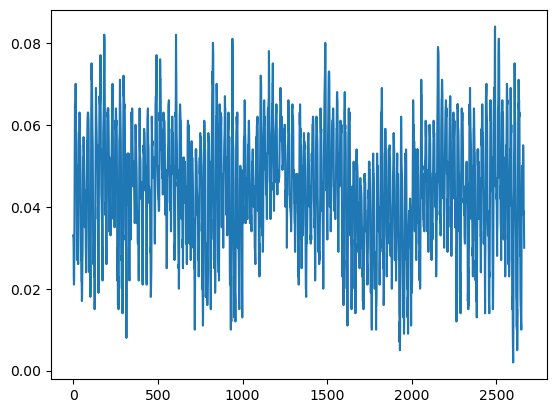

In [52]:
y = np.array(aq_df["sample.measurement"])
df_y = pd.DataFrame(y)
plt.plot(y)

In [53]:
df = pd.DataFrame(phi_1)
df['y'] = df_y[0]
df['site'] = aq_df['site.num'].to_numpy()
df['date'] = aq_df['date'].to_numpy()
df['normalized_time'] = aq_df['normalized_time'].to_numpy()
df.to_csv("./rbfs/phi_1_full.csv")
df = pd.DataFrame(phi_1_reduce)
df['y'] = df_y[0]
df['site'] = aq_df['site.num'].to_numpy()
df['date'] = aq_df['date'].to_numpy()
df['normalized_time'] = aq_df['normalized_time'].to_numpy()
df.to_csv("./rbfs/phi_1_reduce.csv")

### Mobile
Check dimensions and stack (column bind)

In [54]:
print(phi_t2.shape)
print(phi_s2.shape)

phi_2 = np.hstack((phi_t2,phi_s2))

(94272, 86)
(94272, 227)


Remove any columns with all zeros (basis functions not linked to obs)

In [55]:
#idx_zero = np.array([], dtype=int)
#for i in range(phi_2.shape[1]):
#    if sum(phi_2[:,i]!=0)==0:
#        idx_zero = np.append(idx_zero,int(i))

phi_2_reduce = np.delete(phi_2,idx_zero,1)
print(phi_2.shape)
print(phi_2_reduce.shape)

(94272, 313)
(94272, 217)


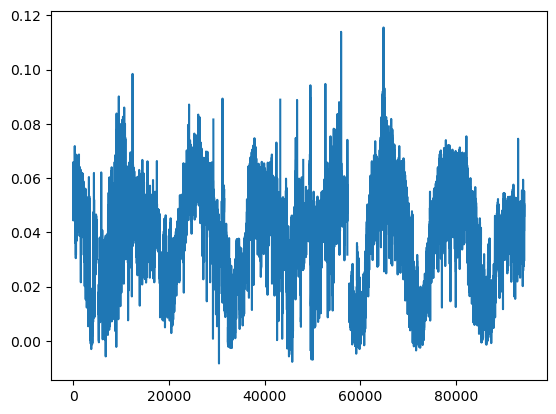

In [56]:
y = np.array(ebus2["val"])
df_y = pd.DataFrame(y)
plt.plot(y)

In [57]:
ebus2

,time,lon,lat,val,normalized_lon,normalized_lat,normalized_time
0,2023-07-01 00:00:00,-111.977234,40.703491,0.0627,0.398841,0.571279,0.000000
1,2023-07-01 00:00:05,-111.977234,40.703499,0.0553,0.398841,0.571295,0.000004
2,2023-07-01 00:00:10,-111.977234,40.703499,0.0537,0.398841,0.571295,0.000008
3,2023-07-01 00:00:15,-111.977234,40.703499,0.0573,0.398841,0.571295,0.000012
4,2023-07-01 00:00:20,-111.977234,40.703499,0.0484,0.398841,0.571295,0.000017
...,...,...,...,...,...,...,...
94267,2023-07-14 22:59:40,-111.916893,40.733463,0.0454,0.485432,0.631527,0.999983
94268,2023-07-14 22:59:45,-111.916924,40.732914,0.0552,0.485387,0.630423,0.999988
94269,2023-07-14 22:59:50,-111.916946,40.732399,0.0507,0.485356,0.629388,0.999992
94270,2023-07-14 22:59:55,-111.916946,40.731895,0.0413,0.485356,0.628375,0.999996


In [58]:
df = pd.DataFrame(phi_2)
df['y'] = df_y[0]
df['date'] = ebus2['time'].to_numpy()
df['normalized_time'] = ebus2['normalized_time'].to_numpy()
df.to_csv("./rbfs/phi_2_full.csv")
df = pd.DataFrame(phi_2_reduce)
df['y'] = df_y[0]
df['date'] = ebus2['time'].to_numpy()
df['normalized_time'] = ebus2['normalized_time'].to_numpy()
df.to_csv("./rbfs/phi_2_reduce.csv")